<a href="https://colab.research.google.com/github/sajjkavinda/cervical-spine-fracture-detection/blob/main/cervical_spine_fracture_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Cervical Spine Fracture Detection**

This notebook demonstrate the process using deep learning to detect and predict human cervical spine fractures from medical imaging data. This project tend to explore a combination of deep learning and computer vision techniques for medical diagnosis, including preprocessing the dataset, model training and testing, evaluation, and prediction.

Dataset Source: https://www.kaggle.com/competitions/rsna-2022-cervical-spine-fracture-detection



In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
!unzip -q "/content/drive/MyDrive/Dataset-RSNA/rsna_subset.zip" -d "/content/rsna_subset" && echo "Unzip completed successfully!"

Unzip completed successfully!


In [38]:
import os
import pydicom
import cv2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [41]:
os.listdir("/content/rsna_subset/rsna_subset_images")[:5]

['1.2.826.0.1.3680043.8562',
 '1.2.826.0.1.3680043.15840',
 '1.2.826.0.1.3680043.3131',
 '1.2.826.0.1.3680043.6741',
 '1.2.826.0.1.3680043.31352']

In [43]:
!pip uninstall -y gdcm python-gdcm pydicom pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg --quiet
!pip install pydicom pylibjpeg pylibjpeg-libjpeg pylibjpeg-openjpeg --quiet
!pip install opencv-python matplotlib tqdm --quiet
!pip install pandas scikit-learn matplotlib tqdm --quiet
!pip install torch torchvision torchaudio --quiet

In [44]:
input_dir = "/content/rsna_subset/rsna_subset_images"
output_dir = "/content/rsna_png_images"
os.makedirs(output_dir, exist_ok=True)

for patient in tqdm(os.listdir(input_dir)):
    patient_path = os.path.join(input_dir, patient)
    if not os.path.isdir(patient_path):
        continue
    patient_output = os.path.join(output_dir, patient)
    os.makedirs(patient_output, exist_ok=True)

    for file in os.listdir(patient_path):
        if file.endswith(".dcm"):
            dcm_path = os.path.join(patient_path, file)
            png_path = os.path.join(patient_output, file.replace(".dcm", ".png"))

            try:
                dcm = pydicom.dcmread(dcm_path)
                img = dcm.pixel_array
                img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
                cv2.imwrite(png_path, img)
            except Exception as e:
                print(f"Error converting {dcm_path}: {e}")


100%|██████████| 800/800 [00:27<00:00, 28.69it/s]


Available fractured: 283, normal: 293
Fractured Study UID: 1.2.826.0.1.3680043.21561
Normal Study UID: 1.2.826.0.1.3680043.849


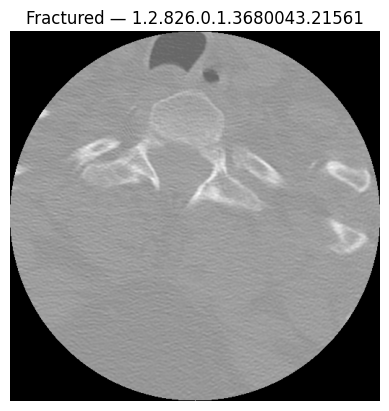

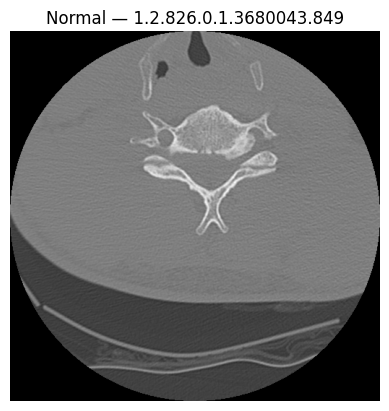

In [45]:
# Load CSV
labels = pd.read_csv("/content/rsna_subset/subset_csv/train.csv")

# Get available folders (already converted)
available_uids = set(os.listdir("/content/rsna_png_images"))

# Filter labels for those that exist in the converted folder
labels_existing = labels[labels["StudyInstanceUID"].isin(available_uids)]

# Separate fractured and normal
fractured_cases = labels_existing[labels_existing["patient_overall"] == 1]
normal_cases = labels_existing[labels_existing["patient_overall"] == 0]

print(f"Available fractured: {len(fractured_cases)}, normal: {len(normal_cases)}")

# Pick one of each
fractured_uid = fractured_cases["StudyInstanceUID"].iloc[0]
normal_uid = normal_cases["StudyInstanceUID"].iloc[0]

print("Fractured Study UID:", fractured_uid)
print("Normal Study UID:", normal_uid)

# Display Images
def show_example(study_uid, label):
    study_path = os.path.join("/content/rsna_png_images", study_uid)
    files = sorted([f for f in os.listdir(study_path) if f.endswith(".png")])

    if not files:
        print(f"No images found for {study_uid}")
        return

    img_path = os.path.join(study_path, files[len(files)//2])  # middle slice
    img = Image.open(img_path)

    plt.imshow(img, cmap="gray")
    plt.title(f"{label} — {study_uid}")
    plt.axis("off")
    plt.show()

show_example(fractured_uid, "Fractured")
show_example(normal_uid, "Normal")


In [47]:
labels = pd.read_csv("/content/rsna_subset/subset_csv/train.csv")

# Keep only the subset
subset_ids = os.listdir("/content/rsna_png_images")
subset_labels = labels[labels["StudyInstanceUID"].isin(subset_ids)][["StudyInstanceUID", "patient_overall"]]

print(subset_labels.head())

            StudyInstanceUID  patient_overall
0  1.2.826.0.1.3680043.21561                1
1  1.2.826.0.1.3680043.18659                1
2    1.2.826.0.1.3680043.849                0
3   1.2.826.0.1.3680043.4744                1
4  1.2.826.0.1.3680043.24946                0


In [48]:
class SpineDataset(Dataset):
    def __init__(self, df, base_dir, transform=None):
        self.df = df
        self.base_dir = base_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        study_uid = row["StudyInstanceUID"]
        label = row["patient_overall"]

        folder = os.path.join(self.base_dir, study_uid)
        files = [f for f in os.listdir(folder) if f.endswith(".png")]
        img_path = os.path.join(folder, files[len(files)//2])  # middle slice

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long)


In [49]:
base_dir = "/content/rsna_png_images"
train_df = labels_existing.sample(frac=0.8, random_state=42)
val_df = labels_existing.drop(train_df.index)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = SpineDataset(train_df, base_dir, transform)
val_dataset = SpineDataset(val_df, base_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)


In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
EPOCHS = 3

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Train loss: {total_loss/len(train_loader):.4f}")


Epoch 1/3: 100%|██████████| 58/58 [00:06<00:00,  8.83it/s]


Train loss: 0.7553


Epoch 2/3: 100%|██████████| 58/58 [00:04<00:00, 11.78it/s]


Train loss: 0.4909


Epoch 3/3: 100%|██████████| 58/58 [00:06<00:00,  9.45it/s]

Train loss: 0.2980


In [52]:
model.eval()
predictions, truths = [], []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, 1).cpu().numpy()
        predictions.extend(preds)
        truths.extend(labels.numpy())

acc = np.mean(np.array(predictions) == np.array(truths))
print(f"Validation Accuracy: {acc:.2%}")


Validation Accuracy: 47.83%


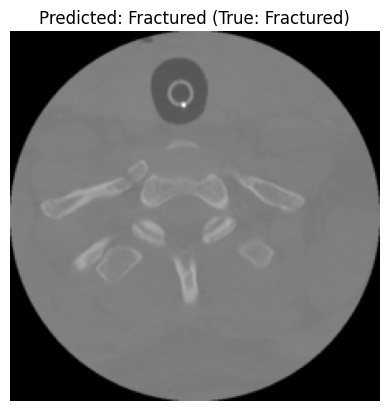

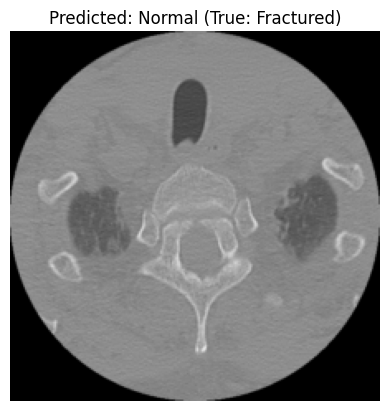

In [53]:
def denormalize(img_tensor):
    """Undo ImageNet normalization to make the image viewable."""
    import torch
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor * std + mean
    img = torch.clamp(img, 0, 1)
    return img

def show_predictions(dataset, model, device, label_names=["Normal", "Fractured"]):
    model.eval()
    shown = {"pos": False, "neg": False}

    for i in range(len(dataset)):
        img, label = dataset[i]
        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(device))
            pred_label = torch.argmax(pred, 1).item()

        # Pick one predicted positive and one predicted negative
        if (pred_label == 1 and not shown["pos"]) or (pred_label == 0 and not shown["neg"]):
            img_vis = denormalize(img)
            plt.imshow(np.transpose(img_vis.numpy(), (1, 2, 0)))
            plt.title(f"Predicted: {label_names[pred_label]} (True: {label_names[label]})")
            plt.axis("off")
            plt.show()

            if pred_label == 1:
                shown["pos"] = True
            else:
                shown["neg"] = True

        if all(shown.values()):
            break

show_predictions(val_dataset, model, device)


In [55]:
data_dir = "rsna_png_images"  # folder containing image folders
train_csv = "/content/rsna_subset/subset_csv/train.csv"
test_csv = "/content/rsna_subset/subset_csv/test.csv"

# Load metadata
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (576, 9)
Test shape: (80, 9)


In [56]:
import os

# Path to your PNG images
data_dir = "rsna_png_images"

# Only keep studies that exist in the folder
available_uids = set(os.listdir(data_dir))
train_df = train_df[train_df["StudyInstanceUID"].isin(available_uids)]
val_df = val_df[val_df["StudyInstanceUID"].isin(available_uids)]

print("Train studies available:", len(train_df))
print("Validation studies available:", len(val_df))

test_df = test_df[test_df["StudyInstanceUID"].isin(available_uids)]
print("Test studies available:", len(test_df))


Train studies available: 576
Validation studies available: 115
Test studies available: 80


In [57]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

class RSNADataset(Dataset):
    def __init__(self, df, data_dir, transform=None):
        self.df = df
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        study_uid = row["StudyInstanceUID"]
        label = int(row["patient_overall"])

        folder = os.path.join(self.data_dir, study_uid)
        files = [f for f in os.listdir(folder) if f.endswith(".png")]
        img_path = os.path.join(folder, files[len(files)//2])  # middle slice
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [58]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df["patient_overall"],  # use correct label column
    random_state=42
)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = RSNADataset(train_df, data_dir, transform)
val_dataset = RSNADataset(val_df, data_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [59]:
from torchvision.models import resnet18, ResNet18_Weights

# Load pre-trained ResNet18 using the new API
weights = ResNet18_Weights.DEFAULT  # latest ImageNet weights
model = resnet18(weights=weights)

# Replace the final layer for binary classification
import torch.nn as nn
model.fc = nn.Linear(model.fc.in_features, 2)

# Move to device
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)
print("Using device:", device)


Using device: cuda


In [70]:
import torch.optim as optim
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

    val_correct, val_total = 0, 0
    model.eval()
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = outputs.max(1)
            val_correct += preds.eq(labels).sum().item()
            val_total += labels.size(0)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {100*correct/total:.2f}% | Val Acc: {100*val_correct/val_total:.2f}%")


100%|██████████| 29/29 [00:07<00:00,  4.02it/s]


Epoch 1/10 | Train Acc: 92.61% | Val Acc: 57.76%


100%|██████████| 29/29 [00:04<00:00,  6.49it/s]


Epoch 2/10 | Train Acc: 93.48% | Val Acc: 68.10%


100%|██████████| 29/29 [00:05<00:00,  5.12it/s]


Epoch 3/10 | Train Acc: 96.30% | Val Acc: 62.07%


100%|██████████| 29/29 [00:04<00:00,  6.39it/s]


Epoch 4/10 | Train Acc: 97.61% | Val Acc: 63.79%


100%|██████████| 29/29 [00:05<00:00,  5.18it/s]


Epoch 5/10 | Train Acc: 97.83% | Val Acc: 60.34%


100%|██████████| 29/29 [00:04<00:00,  6.15it/s]


Epoch 6/10 | Train Acc: 98.91% | Val Acc: 59.48%


100%|██████████| 29/29 [00:05<00:00,  4.99it/s]


Epoch 7/10 | Train Acc: 98.91% | Val Acc: 69.83%


100%|██████████| 29/29 [00:04<00:00,  6.04it/s]


Epoch 8/10 | Train Acc: 99.13% | Val Acc: 63.79%


100%|██████████| 29/29 [00:05<00:00,  5.67it/s]


Epoch 9/10 | Train Acc: 97.17% | Val Acc: 64.66%


100%|██████████| 29/29 [00:04<00:00,  6.09it/s]


Epoch 10/10 | Train Acc: 93.70% | Val Acc: 62.07%


In [71]:
test_dataset = RSNADataset(test_df, data_dir, transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
test_correct, test_total = 0, 0
for imgs, labels in test_loader:
    imgs, labels = imgs.to(device), labels.to(device)
    outputs = model(imgs)
    _, preds = outputs.max(1)
    test_correct += preds.eq(labels).sum().item()
    test_total += labels.size(0)

print(f"est Accuracy: {100*test_correct/test_total:.2f}%")


est Accuracy: 63.75%


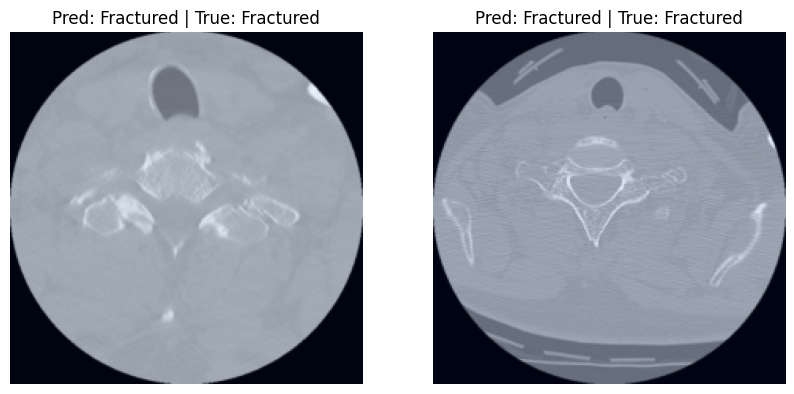

In [74]:
import matplotlib.pyplot as plt
import numpy as np

def show_predictions(model, dataset, n=2):
    model.eval()
    fig, axes = plt.subplots(1, n, figsize=(10, 5))
    for i in range(n):
        img, label = dataset[i]
        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(device))
            pred_label = torch.argmax(pred, dim=1).item()
        img_np = img.permute(1, 2, 0).cpu().numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
        axes[i].imshow(img_np)
        axes[i].set_title(f"Pred: {'Fractured' if pred_label==1 else 'Normal'} | True: {'Fractured' if label==1 else 'Normal'}")
        axes[i].axis("off")
    plt.show()

show_predictions(model, val_dataset, n=2)


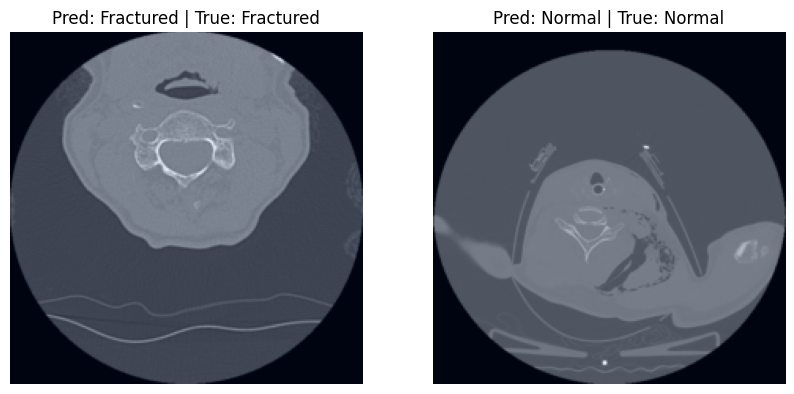

In [77]:
import random

def show_random_predictions(model, dataset, n=2):
    model.eval()
    indices = random.sample(range(len(dataset)), n)  # pick n random images
    fig, axes = plt.subplots(1, n, figsize=(10, 5))

    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        with torch.no_grad():
            pred = model(img.unsqueeze(0).to(device))
            pred_label = torch.argmax(pred, dim=1).item()

        img_np = img.permute(1, 2, 0).cpu().numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

        axes[i].imshow(img_np)
        axes[i].set_title(f"Pred: {'Fractured' if pred_label==1 else 'Normal'} | True: {'Fractured' if label==1 else 'Normal'}")
        axes[i].axis("off")

    plt.show()

show_random_predictions(model, val_dataset, n=2)